# `CIFAR10` Image Classification Challenge (Version-0.4.2)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as tf_hub

TensorFlow 2.x selected.


In [0]:
from PIL import Image
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from matplotlib import style
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import glob
import logging
import numpy as np
import os
import pandas as pd
import shutil
import urllib3

In [0]:
logger = tf.get_logger()

In [0]:
logger.setLevel(logging.ERROR)
style.use('ggplot')
tfds.disable_progress_bar()
urllib3.disable_warnings(category=urllib3.exceptions.InsecureRequestWarning)

In [7]:
splitting = tfds.Split.ALL.subsplit(weighted=(70, 20, 10))
splitting

(NamedSplitAll()(tfds.percent[0:70]),
 NamedSplitAll()(tfds.percent[70:90]),
 NamedSplitAll()(tfds.percent[90:100]))

In [8]:
dataset_cifar10, dataset_info = tfds.load(
    name='cifar10', split=splitting, as_supervised=True, with_info=True)

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/1.0.2. Subsequent calls will reuse this data.


In [0]:
train_dataset, valid_dataset, test_dataset = dataset_cifar10

In [10]:
print(train_dataset)
print(valid_dataset)
print(test_dataset)

<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>


In [0]:
for train_img, train_lab in train_dataset.take(count=1):
  break

tf.Tensor(
[[[ 97 109  91]
  [ 97 113  93]
  [ 91 114  89]
  ...
  [ 59  77  84]
  [ 44  60  63]
  [ 43  55  59]]

 [[100 112  97]
  [ 97 111  95]
  [ 86 110  85]
  ...
  [ 47  62  67]
  [ 49  65  72]
  [ 56  69  80]]

 [[100 115 100]
  [ 99 113 105]
  [ 87 111  95]
  ...
  [ 46  61  65]
  [ 51  69  76]
  [ 63  79  89]]

 ...

 [[119 129 134]
  [110 121 123]
  [107 120 120]
  ...
  [ 98 123 129]
  [119 140 164]
  [124 147 175]]

 [[116 127 128]
  [111 124 129]
  [106 121 124]
  ...
  [113 146 165]
  [117 144 171]
  [114 138 158]]

 [[104 115 111]
  [104 116 114]
  [105 124 125]
  ...
  [129 163 192]
  [128 157 189]
  [118 141 163]]], shape=(32, 32, 3), dtype=uint8)
(32, 32, 3)
tf.Tensor(2, shape=(), dtype=int64)


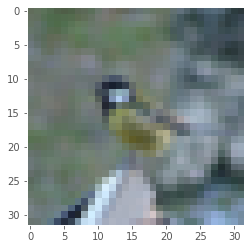

In [12]:
print(train_img)
print(train_img.shape)
print(train_lab)

plt.imshow(train_img)
plt.grid(False)
plt.show()

In [0]:
for valid_img, valid_lab in valid_dataset.take(count=1):
  break

tf.Tensor(
[[[ 35  48  30]
  [ 30  45  24]
  [ 44  62  37]
  ...
  [212 198 174]
  [217 204 180]
  [219 207 183]]

 [[ 38  50  33]
  [ 32  46  27]
  [ 39  55  33]
  ...
  [214 199 177]
  [219 204 183]
  [222 208 186]]

 [[ 36  47  33]
  [ 28  40  26]
  [ 35  49  30]
  ...
  [220 207 187]
  [222 210 190]
  [224 211 192]]

 ...

 [[ 32  30  30]
  [ 26  26  27]
  [ 22  22  24]
  ...
  [165 163 174]
  [156 151 164]
  [159 154 166]]

 [[ 48  44  54]
  [ 46  44  56]
  [ 43  42  54]
  ...
  [145 145 160]
  [149 147 160]
  [160 158 167]]

 [[ 60  60  73]
  [ 61  63  77]
  [ 61  65  78]
  ...
  [149 148 162]
  [162 159 168]
  [198 196 197]]], shape=(32, 32, 3), dtype=uint8)
(32, 32, 3)
tf.Tensor(1, shape=(), dtype=int64)


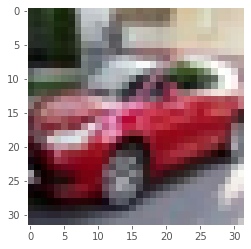

In [14]:
print(valid_img)
print(valid_img.shape)
print(valid_lab)

plt.imshow(valid_img)
plt.grid(False)
plt.show()

In [0]:
def plot_the_aug_images(images_arr):
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
  axes = axes.flatten()

  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.grid(False)
  
  plt.tight_layout()
  plt.show()

### Prepare the Dataset

In [16]:
num_classes_ = dataset_info.features['label'].num_classes
class_label_names = np.array(dataset_info.features['label'].names)

num_training_examples   = 0
num_validation_examples = 0
num_testing_examples    = 0

for train in train_dataset:
  num_training_examples += 1

for valid in valid_dataset:
  num_validation_examples += 1

for test in test_dataset:
  num_testing_examples += 1

print("Number of Classes : {}".format(num_classes_))
for i, class_ in enumerate(class_label_names):
  print(f"{i}  -->  {class_}")

print("\nTraining examples   : {}".format(num_training_examples))
print("Validation examples : {}".format(num_validation_examples))
print("Testing examples    : {}".format(num_testing_examples))

Number of Classes : 10
0  -->  airplane
1  -->  automobile
2  -->  bird
3  -->  cat
4  -->  deer
5  -->  dog
6  -->  frog
7  -->  horse
8  -->  ship
9  -->  truck

Training examples   : 42000
Validation examples : 12000
Testing examples    : 6000


In [0]:
def normalize_images(image, label):
  image = tf.cast(x=image, dtype=tf.float32)
  image /= 255
  return image, label

In [0]:
def ran_flip_lr_(image, label):
  image = tf.image.random_flip_left_right(image=image)
  return image, label

def ran_contrast_(image, label):
  image = tf.image.random_contrast(image=image, lower=0.5, upper=1.5)
  return image, label

In [0]:
train_dataset = train_dataset.map(map_func=ran_flip_lr_)
train_dataset = train_dataset.map(map_func=ran_contrast_)
train_dataset = train_dataset.map(map_func=normalize_images)

valid_dataset = valid_dataset.map(map_func=ran_flip_lr_)
valid_dataset = valid_dataset.map(map_func=ran_contrast_)
valid_dataset = valid_dataset.map(map_func=normalize_images)

In [0]:
trains = [train_img for i in range(5) for train_img, train_lab in train_dataset.take(count=1)]

In [21]:
for i in range(len(trains)):
  for j in range(i, len(trains)):
    print(f"Iteration : ({i}, {j}) : {tf.reduce_all(input_tensor=tf.equal(x=trains[i], y=trains[j]))}")

Iteration : (0, 0) : True
Iteration : (0, 1) : False
Iteration : (0, 2) : False
Iteration : (0, 3) : False
Iteration : (0, 4) : False
Iteration : (1, 1) : True
Iteration : (1, 2) : False
Iteration : (1, 3) : False
Iteration : (1, 4) : False
Iteration : (2, 2) : True
Iteration : (2, 3) : False
Iteration : (2, 4) : False
Iteration : (3, 3) : True
Iteration : (3, 4) : False
Iteration : (4, 4) : True


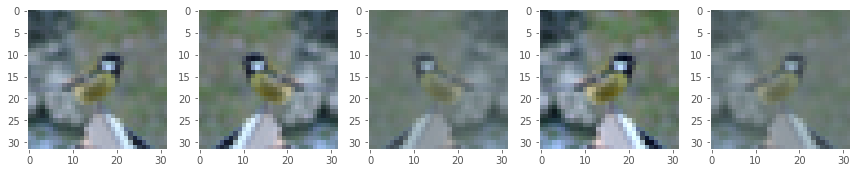

In [22]:
plot_the_aug_images(images_arr=trains)

In [0]:
valids = [valid_img for i in range(5) for valid_img, valid_lab in valid_dataset.take(count=1)]

In [24]:
for i in range(len(valids)):
  for j in range(i, len(valids)):
    print(f"Iteration : ({i}, {j}) : {tf.reduce_all(input_tensor=tf.equal(x=valids[i], y=valids[j]))}")

Iteration : (0, 0) : True
Iteration : (0, 1) : False
Iteration : (0, 2) : False
Iteration : (0, 3) : False
Iteration : (0, 4) : False
Iteration : (1, 1) : True
Iteration : (1, 2) : False
Iteration : (1, 3) : False
Iteration : (1, 4) : False
Iteration : (2, 2) : True
Iteration : (2, 3) : False
Iteration : (2, 4) : False
Iteration : (3, 3) : True
Iteration : (3, 4) : False
Iteration : (4, 4) : True


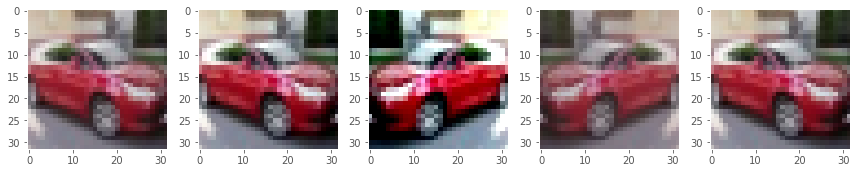

In [25]:
plot_the_aug_images(images_arr=valids)

In [0]:
train_dataset, valid_dataset, test_dataset = dataset_cifar10

In [0]:
train_dataset_generator = ImageDataGenerator(rotation_range=45, 
                                             width_shift_range=0.15, 
                                             height_shift_range=0.15, 
                                             zoom_range=0.2, 
                                             horizontal_flip=True, 
                                             vertical_flip=True, 
                                             rescale=1./255)

In [0]:
for train_img, train_lab in train_dataset.take(count=1):
  break

In [0]:
train_dataset_generator = train_dataset_generator.flow(x=np.array([train_img]))

In [0]:
trains = [train_dataset_generator[0][0] for i in range(5)]

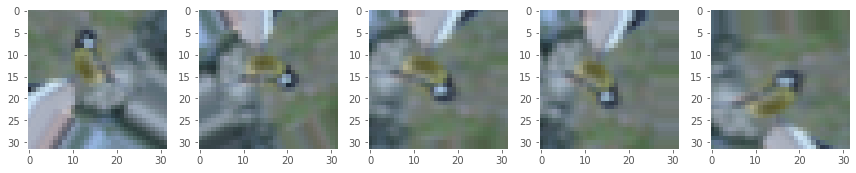

In [31]:
plot_the_aug_images(images_arr=trains)

In [0]:
valid_dataset_generator = ImageDataGenerator(rotation_range=45, 
                                             width_shift_range=0.15, 
                                             height_shift_range=0.15, 
                                             zoom_range=0.2, 
                                             horizontal_flip=True, 
                                             vertical_flip=True, 
                                             rescale=1./255)

In [0]:
for valid_img, valid_lab in valid_dataset.take(count=1):
  break

In [0]:
valid_dataset_generator = valid_dataset_generator.flow(x=np.array([valid_img]))

In [0]:
valids = [valid_dataset_generator[0][0] for i in range(5)]

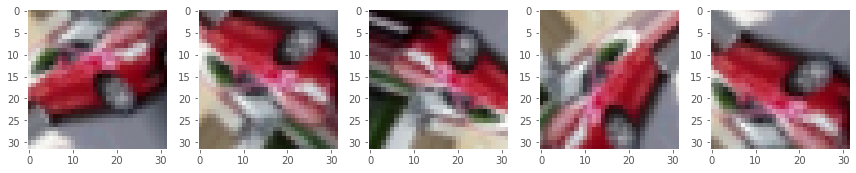

In [36]:
plot_the_aug_images(images_arr=valids)

In [0]:
train_dataset, valid_dataset, test_dataset = dataset_cifar10

In [0]:
BATCH_SIZE = 32
IMG_SIZE = 32

In [0]:
image_generator_train = ImageDataGenerator(rotation_range=45, 
                                           width_shift_range=0.15, 
                                           height_shift_range=0.15, 
                                           zoom_range=0.2, 
                                           horizontal_flip=True, 
                                           vertical_flip=True, 
                                           rescale=1./255)

In [0]:
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=1)

In [0]:
for train_img_lab in train_dataset.take(count=1):
  break

In [44]:
train_img_lab[0].numpy().shape

(32, 32, 32, 3)